# Movie Reviews

The goal of this project is to analyse IMDB movie review texts using various NLP techniques and libraries. A dataset that we are going to use is meant mainly for **binary sentiment classification** and performing this particular type of analysis will, indeed, be our primary goal, but additionally, we'll **use POS tagging and chunking to find commonly used noun and verb phrases** and **find the most common movie topics users wrote about (topic modelling using LDA)**. All these techniques should give us insights into review texts on different levels as well as give us a new model to perform topic modelling on similar datasets as well as a sentiment analysis model to identify positive or negative reviews. 

Thanks to authors of this dataset it contains substantially more data than previous benchmark datasets. They provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. In this regard, I respectfully would like to draw your attention to their research paper: [Learning Word Vectors for Sentiment Analysis](https://aclanthology.org/P11-1015) (Maas et al., ACL 2011)

## EDA

Let's import necessary libraries and methods crucial for further work and look at our dataset. We are going to upload data via `pandas` to see if it would facilitate further analysis.

In [1]:
# Basic imports
import numpy as np
import pandas as pd

# Imports for files processing
import os
import pickle

# Imports for visualisation
from IPython.display import display
from IPython.display import HTML

# Imports for preprocessing
from nltk.corpus import stopwords
import re, nltk
from nltk import pos_tag_sents, RegexpParser
from nltk import word_tokenize, sent_tokenize

Note: we are going to use `pickle` to speed up running time, so in some cells will be placed `pickle` functions.

In [2]:
def pickle_object(object, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(object, f)

def unpickle_object(file_path):
    if not os.path.isfile(file_path):
        return None
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def with_pickle(file_path, fun):
    value = unpickle_object(file_path)
    if value is None:
        value = fun()
        pickle_object(value, file_path)
    return value

Now let's upload data into `pandas` DataFrame and see first several rows. 

In [82]:
movie_reviews = pd.read_csv('data/imdb_dataset.csv')
# Display full length text in column
pd.options.display.max_colwidth = None
movie_reviews.head(5)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

Reviews text is medium length and does not look too noisy from the first glance. We see some HTML tags and that's basically it for the first few texts. We are going to check in depth some other "noise issues" of this text, but let's first check how many positive and negative reviews this dataset contains exactly. 

In [4]:
(movie_reviews.sentiment =='negative').sum()

25000

In [5]:
(movie_reviews.sentiment =='positive').sum()

25000

In [6]:
len(movie_reviews)

50000

So, of 50 thousand reviews exactly half marked as "negative" and the other half as "positive". Considering, there are only 2 columns in this DataFrame, which are "review" texts themselves and their "sentiment", there is not much quck insights we can get out of the dataset without applying NLP methods, so let's get to noise removal part.

## Noise Removal

We'll start with pretty standart noise removal:
- HTML tags;
- Links.


In [7]:
def remove_html_tags():
    return movie_reviews.review.str.replace(r'<br />|</?(i|p|em|hr)|', '', regex=True)

# Remove HTML tags
movie_reviews.review = with_pickle('pickles/html_tags_removed.pickle', remove_html_tags)

In [8]:
# Remove links
movie_reviews.review = movie_reviews.review.str.replace(r'''[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)''', '', regex=True)

To check the results after applying our noise removal `regex` expressions and find other different flaws of this dataset we'll use pretty sophysticated codesnippet from StackOverflow which highlights user entered strings or regex expressions. 

Using this method we may not only check data for noise, but also find some interesting text properties, like `emoticons`. There is a huge ammount of valuable sentiment information hidden withing these symbols, yet not many public libraries are capable of their efficient interpretation. After some reseach of available libraries I decided to leave these symbols as they are, but in the future it could be benificial to "translate" them to text strings, meaningful for text processing algorithms. There are some examples of text containing different types of `emoticons` below. 

In [9]:
def display_highlighted_words(df, keywords):
    head = """
    <table>
        <thead>
            """ + \
            "".join(["<th> %s </th>" % c for c in df.columns])\
            + """
        </thead>
    <tbody>"""

    for i,r in df.iterrows():
        row = "<tr>"
        for c in df.columns:
            matches = []
            for k in keywords:
                for match in re.finditer(k, str(r[c])):
                    matches.append(match)
        
            # reverse sorting
            matches = sorted(matches, key = lambda x: x.start(), reverse=True)
        
            # building HTML row
            cell = str(r[c])
            for match in matches:
                cell = cell[:match.start()] +\
                    "<span style='color:red;'>%s</span>" % cell[match.start():match.end()] +\
                    cell[match.end():]
            row += "<td> %s </td>" % cell
                
            row += "</tr>"
        head += row

    head += "</tbody></table>"
    display(HTML(head))

display_highlighted_words(movie_reviews[movie_reviews.review.str.contains(r':-\)')][:2], [':-\)'])


"I have to say that this miniseries was the best interpretation of the beloved novel ""Jane Eyre"". Both Dalton and Clarke are very believable as Rochester and Jane. I've seen other versions, but none compare to this one. The best one for me. I could never imagine anyone else playing these characters ever again. The last time I saw this one was in 1984 when I was only 13. At that time, I was a bookworm and I had just read Charlotte Bronte's novel. I was completely enchanted by this miniseries and I remember not missing any of the episodes. I'd like to see it again because it's so good. :-)",positive
"This was one of my favorite series when I was a kid. The Swedish broadcasting company decided to broadcast it once again a couple of summers ago when I had just finished my first semester of medical school. I was surprised to see the depth in which the organs was explained. Sure, some things are simplified but most of it was correct (even though it was made 22 years ago!) and quite understandable. I would suggest that all soon-to-be medical student should watch it. It is a very good way to learn some of the basic medical words for example. Now I'm in my 7th semester and I think I'll watch the series once again as soon as I've bought the DVD-box :-)",positive


In [10]:
display_highlighted_words(movie_reviews[movie_reviews.review.str.contains(r'\^_+')][2:4], ['_', '\^', '-', '~', '='])

"Since the last horrid Astérix film and the fact that we only get the Swiss German version in cinemas, here, I went to watch it with quite a bit of trepidation... Unfounded, as I was happy to discover ^____^The film is funny and modern, has good gags, a good animation, an amusing character interaction, a good voice cast (Note: I can only speak for the Swiss German one!) except for the Viking chief's daughter Abba (her name is great, despite the not very inspired voice actress)...I especially liked the character Justforkix (Goudurix in French, Grautvornix in German. He's the young man who is supposed to be put in shape...). He's a very amusing portrayal of a mollycoddled, urban teenager; but he's very likable, despite the teenage mannerisms... XD The interaction between Astérix & Obélix and their young charge is fantastic and thoroughly entertaining.It shouldn't be compared to the old films, since this one is quite different... Which surprisingly doesn't make it bad. On the contrary. When they tried to modernize the last film (twelve years ago), they completely blew it. This film, however, proved that it can be done just fine... ^-^I came out of the theater cheerful... Always a good sign ^_~",positive
"Just finished watching the movie and wanted to give my own opinion(and justice) to the movie.First of all, to get things straight, this movie is not pretending to be anything other than a solid action comedy movie. It doesn't aim to revolutionize the movie industry and garner critical acclaims nor does it want to be regarded as one. If you really want to enjoy this movie to the fullest, I suggest you discard your critical-mindedness and your longing for a good plot because you won't find any in here. With that established, let us further into the movie.I had low expectations for this movie simply because it didn't have a strong plot(Yes, moviegoers, I underrated this movie as well), but I never expected myself to enjoy this movie that much. I even enjoyed this more than the Stephen Chow flicks(which I find Kung Fu Hustle to be his best effort and would've rated it a 9 as well). Action is tight and epic while comedy chokes on to the right places.SPOILERS alert, I think The action might be unreal, but why would I want to watch a serious basketball movie anyways? There are a lot other sports movies(drama) that already did it well, why create another? SPOILERS endI'm not even sure why you're reading this. Go ahead and watch it. Just remember, no thinking - just watch, enjoy, smile, laugh, and Every once in a while they(the movie industry) creates masterpieces such as Pulp Fiction or The Godfather movies, and sometimes they create movies which are better off in the pile of dump. I'm not saying Kung Fu Dunk deserves the recognition that the previous examples have, then again, if we're talking about Stephen Chow-ish comedy, this one's a top ten.Highly recommended if you love: -no brainer movies with really good action -Kung Fu -Death Trance -Kung Fu and comedy -what the heck, watch this. you'll have a great time.9/10 for you the cast of Kung Fu Dunk. ^_^",positive


Other interesting thing that is probably specific to reviews in general - users tend to give their personal score on the scale from 1 to 10, which can be a big help for machine learning algorithms if interpreted correctly. As well as `emoticons`, `user scores` are worth looking into on the further stages of algorithms tunning so I'll leave them in place with other digits for now, since they will not affect the first part of our analysis. 

### Pre-processing: phase 1

Now that we removed at least some noise we are going to apply text preprocessing methods. We are going to need part of speech tagging applied to these reviews so we can use chunk grammar to determine common verb and noun phrases. To make part of speech tagging more relevant, fast and efficient we will apply the `pos_tag` method to the whole, mostly unchanged, sentence, this way parts of speech will be determined by context hence, in theory, it would yield a more accurate result. 

To achieve it we first are going to tokenise each review by sentence and then by words before feeding it to the `tag_sents` method.

In [11]:
def word_sent_tokenize(text):
    word_sent_tokenized = [word_tokenize(s) for s in sent_tokenize(text)]
    return word_sent_tokenized

In [12]:
def tokenize_df():
    return movie_reviews.review.apply(word_sent_tokenize)

movie_reviews['sent_tokenized'] = with_pickle('pickles/sent_tokenized.pickle', tokenize_df)

In [13]:
def tag_sents():
    return movie_reviews.sent_tokenized.apply(pos_tag_sents)

movie_reviews['sent_pos_tagged'] = with_pickle('pickles/pos_tagged.pickle', tag_sents)

## Sentences Chunking

Now that we have part-of-speech tagged our texts, we can move on to syntax parsing. We are going to use different mixes of chunk grammar within Noun and Verb Phrases to perform it.

In [14]:
def np_chunking_text(pos_tagged_text):
    # Noun phrase chunk grammar
    np_chunk_grammar = r'NP: {<JJ.*>+<NN.*>+|<NN.*>+<JJ.*>+|<RB.*>+<NN.*>+|<NN.*>+<RB.*>+|<RB.*>+<JJ.*>+|<NN.*>+<NN.*>+}'

    # Create NP RegexpParser object
    np_chunk_parser = RegexpParser(np_chunk_grammar) 

    np_chunked_text = [np_chunk_parser.parse(w) for w in pos_tagged_text]

    return np_chunked_text

In [15]:
def vp_chunking_text(pos_tagged_text):
    # Verb phrase chunk grammar
    vp_chunk_grammar = r'VP: {<JJ.*>*<RB.*>*<NN.*>+<VB.*>+|<NN.*>+<VB.*>+<JJ.*>*<RB.*>*|<RB.*>+<NN.*>+<VB.*>+|<JJ.*>+<VB.*>+}'

    # Create VP RegexpParser object
    vp_chunk_parser = RegexpParser(vp_chunk_grammar) 

    vp_chunked_text = [vp_chunk_parser.parse(w) for w in pos_tagged_text]

    return vp_chunked_text


In [16]:
def np_rows_chunking():
    return movie_reviews.sent_pos_tagged.apply(np_chunking_text)

movie_reviews['np_chunked'] = with_pickle('pickles/np_chunked.pickle', np_rows_chunking)


In [17]:
def vp_rows_chunking():
    return movie_reviews.sent_pos_tagged.apply(vp_chunking_text)

movie_reviews['vp_chunked'] = with_pickle('pickles/vp_chunked.pickle', vp_rows_chunking)

Let's see an example of NP chunk to understand what phrases we could get.

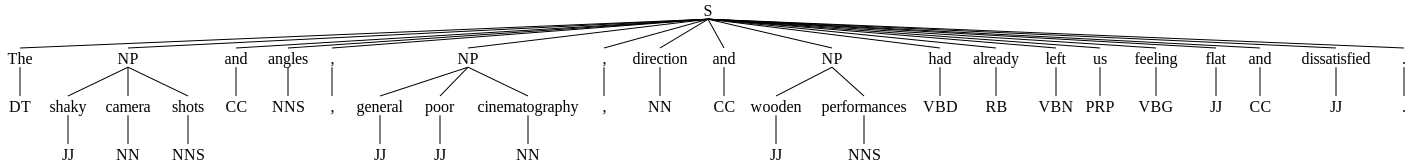

In [18]:
display(movie_reviews.np_chunked[424][3])

Looks good, what about VP chunks? 

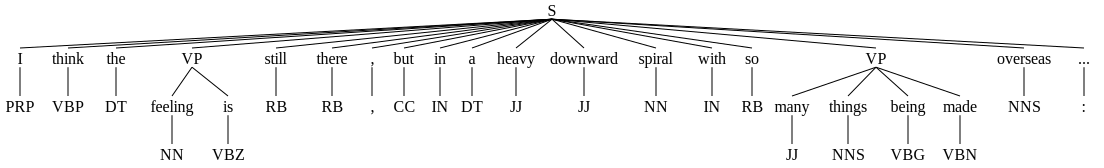

In [19]:
display(movie_reviews.vp_chunked[44][7])

Also quite good, but we probably need to remove stop words to get most common phrases. We are going to use default `nltk` stop words list, but also put some common words from this corpora to get more meaningful results. Initial results contained a lot of phrases with a word "film" or "movie" which is expected from this corpora and does not tell us anything new.

In [20]:
stop_words = set(stopwords.words('english'))
custom_stop_words = [
    'anyone', 'goes', 'give', 'make', 'made', 'get', 'going', 'gets', 'better', 'done', 'worse', 'everyone', 'great', 'even',
    'someone', 'n\'t', 'something', 'best', 'worst', 'anything', 'everything', 'nothing', 'worth', 'years', 'year', 'people',
    'movie', 'one', 'story', 'plot', 'film', 'films', 'good', 'really', 'first', '*', 'thing', 'many', 'much', 'really', 'things',
    'last', 'next', 'main', 'bad', 'long', 'bit', 'second', 'several', 'lot', 'named', 'seem', 'seemed', 'seems', 'Everyone', 'Go', 'IT', 
    'come', 'go', 'take', 'however', 'also', 'quite', 'may', 'rather',  'yet', 'find', 'take', 'would', 'see', 'like', 'say', 'know',
    'could', 'want']
stop_words = stop_words.union(custom_stop_words)

In [21]:
def chunk_counter(column, label, stopwords = []):
    word_freq = nltk.FreqDist()
    for review in column:
        for tree in review:
            for chunk in tree.subtrees(lambda node: 
                    node.label() == label
                    and sum([word in stopwords for (word, tag) in node.leaves()]) == 0):
                word_freq[str(chunk.flatten())] += 1
    return word_freq

Let's review 50 most common noun phrases from 50 thousand reviews texsts. 

In [22]:
chunk_counter(movie_reviews.np_chunked, 'NP', stop_words).most_common(50)

[('(NP special/JJ effects/NNS)', 1284),
 ('(NP New/NNP York/NNP)', 634),
 ('(NP real/JJ life/NN)', 622),
 ('(NP character/NN development/NN)', 431),
 ('(NP low/JJ budget/NN)', 390),
 ('(NP big/JJ fan/NN)', 360),
 ('(NP young/JJ man/NN)', 360),
 ('(NP high/JJ school/NN)', 358),
 ('(NP big/JJ screen/NN)', 337),
 ('(NP young/JJ woman/NN)', 290),
 ('(NP camera/NN work/NN)', 285),
 ('(NP TV/NN series/NN)', 279),
 ('(NP subject/JJ matter/NN)', 269),
 ('(NP production/NN values/NNS)', 267),
 ('(NP old/JJ man/NN)', 254),
 ('(NP little/JJ girl/NN)', 248),
 ('(NP action/NN scenes/NNS)', 248),
 ('(NP United/NNP States/NNPS)', 243),
 ('(NP young/JJ girl/NN)', 239),
 ('(NP horror/NN movies/NNS)', 236),
 ('(NP fight/NN scenes/NNS)', 224),
 ('(NP final/JJ scene/NN)', 223),
 ('(NP huge/JJ fan/NN)', 219),
 ('(NP small/JJ town/NN)', 216),
 ('(NP serial/JJ killer/NN)', 207),
 ('(NP TV/NN show/NN)', 205),
 ('(NP sex/NN scenes/NNS)', 201),
 ('(NP Star/NNP Wars/NNP)', 200),
 ('(NP video/NN store/NN)', 191),

There are some interersting findings, for example: 
- The absolute hero in mention count is a noun phrase `special effects`, with the count 1284.
- Most common city names are `New-York` (more than 700 times), `Los Angeles` (168) and `Hong Kong` (143). 
- Quite big mention count compared to others has a phrase `real life` with 622 of them as well as `real world` with 178. 
- Most common country name is the `US` (243). 
- There are a few big movies and TV series projects mentioned like `Star Wars` (200) and `Star Treck` (148).
- The unexpected finding is `World War II`, which is still mentioned 158 times many years after.
- `Low budget` is mentioned 390 times, which is significant compared to other phrases. At the same time any variations of `big budget` didn't get into the list. 
- There are some generic phrases describing characters age and gender: `young man` (360 times mentioned), `young woman` (290), `old man` (254), `little girl` (248), `young girl` (239), `young boy` (164), `little boy` (140). 
- There are many phrases that are specific to the sphere, like: `big screen` (337), `camera work` (285), `TV series` (279), `production values` (267), `action scenes` (248), `horror movies` (236), `fight scenes` (224), `final scene` (223), `sex scenes` (201), `video store`(191), `opening credits` (184), `box office` (159), `screen time` (157), `lead character` (147), `comic relief` (146).
- Apparantly there are a lot of movies picturing a `small town` (216 metiones) and `serial killer` (207).
- Some reviewers also mentioned `musical score` (146) in their reviews.

In [23]:
chunk_counter(movie_reviews.vp_chunked, 'VP', stop_words).most_common(50)

[('(VP happy/JJ ending/VBG)', 183),
 ('(VP time/NN watching/VBG)', 120),
 ('(VP pun/NN intended/VBN)', 64),
 ('(VP cast/NN includes/VBZ)', 59),
 ('(VP life/NN watching/VBG)', 50),
 ('(VP familiar/JJ faces/VBZ)', 49),
 ('(VP end/NN credits/VBZ)', 49),
 ('(VP actor/NN playing/VBG)', 47),
 ('(VP Simply/NNP put/VBD)', 46),
 ('(VP old/JJ fashioned/VBN)', 45),
 ('(VP character/NN played/VBN)', 44),
 ('(VP cult/NN following/VBG)', 43),
 ('(VP cheap/JJ looking/VBG)', 43),
 ('(VP actors/NNS playing/VBG)', 42),
 ('(VP middle/JJ aged/VBN)', 42),
 ('(VP action/NN takes/VBZ)', 41),
 ('(VP God/NNP knows/VBZ)', 36),
 ('(VP actors/NNS look/VBP)', 35),
 ('(VP scenes/NNS involving/VBG)', 33),
 ('(VP predictable/JJ ending/VBG)', 33),
 ('(VP heavy/JJ handed/VBN)', 33),
 ('(VP Highly/NNP recommended/VBD)', 33),
 ('(VP minute/NN running/VBG)', 32),
 ('(VP action/NN packed/VBD)', 31),
 ('(VP fun/NN watching/VBG)', 31),
 ('(VP surprise/NN ending/VBG)', 29),
 ('(VP actress/NN playing/VBG)', 29),
 ('(VP award/N

In VP list we concentrated on descriptive verb phrases that are not filled with too common words like "worth" plus verb, or forms of "to be" plus "actor" word, that absolutely dominate the review corpora though don't add any specifics. In the end we got the following statistics: 

- There are many phrases that describe movie or series endings, like: `predictable ending` (33), `surprise ending` (29), `twist ending` (25), `happy ending` dominates this list though, with the count 183.
- Phrase `pun intended` (64) pops up quite often.
- Some phrases were many times incorrectly determined as VP, like `familiar faces` (49).
- There are some negative descriptive phrases like: `cheap looking` (43), `heavy handed` (33), `poor acting` (26), `terrible acting` (22).
- And some positive: `Highly recommended` (33), `fun watching` (31), `award winning` (29), `Worth seeing` (27).
- Some context dependant descriptive phrases: `old fashioned` (45), `God knows` (36), `action packed` (31), `well known` (28),`light hearted` (27),  `computer generated` (25), `slow moving` (23).
- Some industry generic phrases like `time watching` (120), `cast includes` (59), `end credits` (49) etc.
- Unexpected finding like `cult following` with 43 mentions.
- Characters or actors involving phrases: `actor playing` (47), `character played` (44), `actors playing` (42), `actors look` (35), `actress playing` (29), `characters come` (23), `guy playing` (22).

## Topic Modelling via LDA model

We are going to use a Latent Dirichlet Allocation model to perform our topic modelling. LDA is an unsupervised, machine learning, clustering technique that is commonly used in the commercial field for text analysis. Our IMDB corpora set is quite extensive, so this model will take time to train itself. But first, let's prepare our texts in a more thorough way than before and add some additional preprocessing steps. 

### Preprocessing: phase 2

- lower-case;
- remove punctuation;
- remove digits;
- lemmatise.

Considering that we performed minimum preprocessing for POS tagging continue preprocessing with current tags will be a bit more tedious, but manageable. Let's hope our contextual pos-tags are better than dictionary-based. To map tags from `sent_pos_tagged` and those which are accepted by `lemmatiser` we are going to use a `tag_map` located in a separate file. 

In [24]:
# Imports relatied to modeling
from gensim.models import Phrases
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Imports related to visualisation
import matplotlib.pyplot as plt

# Imports related to preprocessing
from nltk.stem import WordNetLemmatizer
from tag_map import tag_map

In [25]:
normalizer = WordNetLemmatizer()
def lemmatise_text(reviews):
    return [[normalizer.lemmatize(token, tag_map[tag] or 'n').lower() for (token, tag) in review] for review in reviews]

# Testing lemmatisation and lowercasing on the 1st sentence of sent_pos_tagged
movie_reviews[:1].sent_pos_tagged.apply(lemmatise_text)

0    [[one, of, the, other, reviewer, have, mention, that, after, watch, just, 1, oz, episode, you, 'll, be, hook, .], [they, be, right, ,, as, this, be, exactly, what, happen, with, me.the, first, thing, that, strike, me, about, oz, be, it, brutality, and, unflinching, scene, of, violence, ,, which, set, in, right, from, the, word, go, .], [trust, me, ,, this, be, not, a, show, for, the, faint, hearted, or, timid, .], [this, show, pull, no, punch, with, regard, to, drug, ,, sex, or, violence, .], [its, be, hardcore, ,, in, the, classic, use, of, the, word.it, be, call, oz, as, that, be, the, nickname, give, to, the, oswald, maximum, security, state, penitentary, .], [it, focus, mainly, on, emerald, city, ,, an, experimental, section, of, the, prison, where, all, the, cell, have, glass, front, and, face, inwards, ,, so, privacy, be, not, high, on, the, agenda, .], [em, city, be, home, to, many, .., aryans, ,, muslims, ,, gangsta, ,, latinos, ,, christians, ,, italians, ,, irish, and, s

In [26]:
# Create list of lists with all words for processing
docs = []
for review in movie_reviews.sent_pos_tagged.apply(lemmatise_text):
    doc = []
    for sentence in review:
        doc += sentence
    docs.append(doc)

# Remove numbers, but not words that contain numbers
docs = [[token for token in doc if not token.isnumeric() and not token in stop_words and re.match(r'\W+', token) is None] for doc in docs]

# Remove words that are only one character
docs = [[token for token in doc if len(token) > 1] for doc in docs]
docs[1][:10]

['wonderful',
 'little',
 'production',
 'filming',
 'technique',
 'unassuming-',
 'old-time-bbc',
 'fashion',
 'comforting',
 'sometimes']

### Building N-gram Phrase Model

Before feature engineering and vectorization, we want to extract some useful n-gram-based phrases from our texts and remove some unnecessary terms. To achieve it we'll leverage a `gensim's` model `Phrases` and active `Dictionary`. It will help us automatically detect common phrases from a stream of sentences, which are typically multi-word expressions, and filter our super common or rare words that are not good candidates for topic modelling.  

In [28]:
bigram = Phrases(docs, min_count=3, threshold=20, delimiter='_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[docs[4]][:50])

['petter', 'mattei', 'love', 'time', 'money', 'visually_stunning', 'watch', 'mr.', 'mattei', 'offer', 'vivid_portrait', 'human_relation', 'tell', 'money', 'power', 'success', 'different', 'situation', 'encounter', 'variation', 'arthur', 'schnitzler', 'play', 'theme', 'director', 'transfer', 'action', 'present', 'time', 'new_york', 'different', 'character', 'meet', 'connect', 'connect', 'way', 'another', 'person', 'previous', 'point', 'contact', 'stylishly', 'sophisticated', 'luxurious', 'look', 'live', 'world', 'live', 'habitat.the', 'soul']


In [29]:
docs_bigrams = [bigram_model[doc] for doc in docs]

Now let's remove too rare or common tokens.

In [30]:
# Create a dictionary representation of the documents
dictionary = Dictionary(docs_bigrams)

# Filter out words that occur less than 20 documents, or more than 60% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.6)

### Vectorization with BoW

In [31]:
# Bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in docs_bigrams]

In [32]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(bow_corpus))

Number of unique tokens: 16371
Number of documents: 50000


### Training LDA model

We have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics as well. We'll start with 10 and see what we'll get. 

In [33]:
# Activate logging if required
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

def train_lda(num_topics, chunksize, passes, iterations, eval_every=None):

    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    # Train LDA model
    return LdaModel(
        corpus=bow_corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        random_state=1234
    )

# Serialise lda model with 10 topics
lda_model = with_pickle('pickles/lda_model.pickle', lambda : train_lda(num_topics=10, chunksize=2000, passes=600, iterations=5000))

### Evaluating topic model quality

We can use perplexity and coherence scores as measures to evaluate the topic model. Typically, lower the perplexity, the better the model. Similarly, the lower the UMass score and the higher the Cv score in coherence, the better the model.

In [34]:
def coherance_and_perplexity(model_name):
    # Find c_v coherance
    cv_coherence_model_lda = gensim.models.CoherenceModel(model=model_name, corpus=bow_corpus, 
                                                                texts=docs_bigrams,
                                                                dictionary=dictionary, 
                                                                coherence='c_v')
    avg_coherence_cv = cv_coherence_model_lda.get_coherence()

    # Find u_mass coherance
    umass_coherence_model_lda = gensim.models.CoherenceModel(model=model_name, corpus=bow_corpus, 
                                                            texts=docs_bigrams,
                                                            dictionary=dictionary, 
                                                            coherence='u_mass')
    avg_coherence_umass = umass_coherence_model_lda.get_coherence()

    # Find perplexity
    perplexity = model_name.log_perplexity(bow_corpus)

    print('Avg. Coherence Score (Cv):', avg_coherence_cv),\
    print('Avg. Coherence Score (UMass):', avg_coherence_umass),\
    print( 'Model Perplexity:', perplexity)


In [35]:
# Find coherance and perplexity for model with 10 topics
coherance_and_perplexity(lda_model)

Avg. Coherence Score (Cv): 0.36492368406056286
Avg. Coherence Score (UMass): -2.9889340662978254
Model Perplexity: -8.3384680836938


### LDA Tuning: Finding the optimal number of topics

LDA is an unsupervised technique, meaning that we don’t know prior to running the model how many topics exits in our corpus. So to find the optimal number of topics. We'll need to build many LDA models with constantly small number of passes and iterations, but with different number of topics for each. This way we will be able to pick the one that gives good evaluative metrics values, but does not put same words in different topics to often.

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step, coherence_type):
    """
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=1234)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_type)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
# Set x params: different number of topics for each model
limit=40; start=2; step=6

# Compute c_v coherence for various number of topics
model_list_c_v, coherence_values_c_v = with_pickle(\
    'pickles/compute_coherence_values_c_v.pickle',\
    lambda : compute_coherence_values(
        dictionary=dictionary, 
        corpus=bow_corpus, 
        texts=docs_bigrams, 
        start=start, 
        limit=limit, 
        step=step, 
        coherence_type='c_v')) 

model_list_u_mass, coherence_values_u_mass = with_pickle(\
    'pickles/compute_coherence_values_u_mass.pickle',\
    lambda : compute_coherence_values(
        dictionary=dictionary, 
        corpus=bow_corpus, 
        texts=docs_bigrams, 
        start=start, 
        limit=limit, 
        step=step, 
        coherence_type='u_mass')) 


In [38]:
# Draw topics and coherence on graph
def coherence_graph(coherence_values):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    return plt.show()

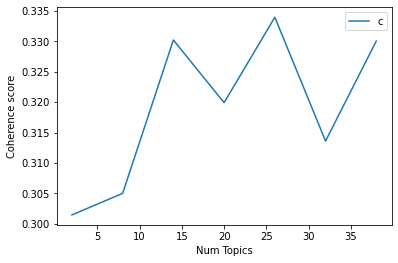

In [39]:
coherence_graph(coherence_values_c_v)

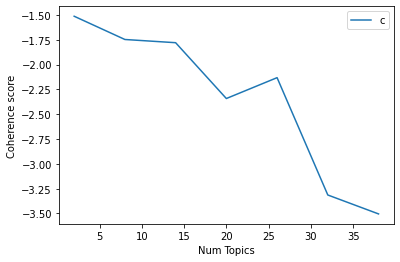

In [40]:
coherence_graph(coherence_values_u_mass)

Result: looks like an optimal number of topics is somewhere around 14, let's try to train the LDA model with 14 topics because with more topics we risk getting too many duplicates in different topics.

In [41]:
# Serialise lda model with 20 topics
lda_model_14 = with_pickle('pickles/lda_model_14.pickle', lambda : train_lda(num_topics=14, chunksize=2000, passes=600, iterations=5000))

In [42]:
# Find coherance and perplexity for model with 20 topics
coherance_and_perplexity(lda_model_14)

Avg. Coherence Score (Cv): 0.36578543858700513
Avg. Coherence Score (UMass): -3.6416493523728053
Model Perplexity: -8.575068039197376


### Viewing LDA Model topics

Let's see what key words topics of different models contain. 

In [43]:
def display_keyw_per_topic(model):
    topics = [[(term, round(probability, 3)) 
               for term, probability in model.show_topic(n, topn=20)] 
                   for n in range(0, model.num_topics)]
    
    pd.set_option('display.max_colwidth', None)

    topics_df = pd.DataFrame([', '.join([term for term, probability in topic]) for topic in topics],
                            columns = ['Key Words per Topic'],
                            index=['Topic'+str(t) for t in range(1, model.num_topics+1)])
    return topics_df

In [44]:
# Display top 20 keywords per topic, when there are 10 topics
display_keyw_per_topic(lda_model)

,Key Words per Topic
Topic1,"watch, think, time, well, look, end, scene, character, way, ever, actor, never, try, funny, actually, acting, little, still, part, act"
Topic2,"song, dance, musical, sing, joe, george, scott, sam, music, tony, number, singer, dancing, stage, jackson, broadway, dancer, mgm, rose, julie"
Topic3,"character, work, performance, role, director, world, two, way, life, audience, become, well, excellent, without, use, scene, viewer, real, different, feel"
Topic4,"original, horror, special_effect, flick, effect, sequel, scary, monster, cheap, zombie, gore, dark, blood, remake, cheesy, low_budget, classic, genre, creepy, killer"
Topic5,"love, old, play, life, young, girl, kid, family, live, child, friend, day, father, little, boy, always, wonderful, mother, beautiful, new"
Topic6,"play, include, star, action, set, feature, appear, early, lead, involve, murder, hero, release, city, sequence, career, late, cop, usual, villain"
Topic7,"sex, japanese, russian, bond, lee, fight, battle, fight_scene, chinese, sex_scene, martial_art, japan, opera, rape, porn, lesbian, imagery, asian, alice, fighting"
Topic8,"show, series, episode, tv, war, american, documentary, country, history, television, british, season, soldier, air, america, new, german, interview, political, god"
Topic9,"book, version, game, novel, play, adaptation, read_book, read, player, sport, charlie, jane, smith, ben, ray, team, de, johnny, billy, nick"
Topic10,"man, woman, kill, two, back, run, men, head, end, leave, house, die, turn, guy, three, another, shoot, death, night, start"


In [45]:
# Display top 20 keywords per topic, when there are 14 topics
display_keyw_per_topic(lda_model_14)

,Key Words per Topic
Topic1,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"
Topic2,"young, kid, family, child, wife, father, mother, son, daughter, husband, sister, parent, old, adult, marry, age, home, fall_love, dad, joe"
Topic3,"character, work, performance, role, director, become, audience, two, scene, use, without, lead, excellent, viewer, set, interesting, although, perhaps, bring, point"
Topic4,"scene, look, acting, script, horror, minute, original, pretty, poor, instead, terrible, shot, dialogue, least, use, idea, awful, effect, boring, sound"
Topic5,"play, star, music, classic, feature, song, release, hollywood, include, late, voice, early, picture, talent, production, number, career, score, soundtrack, mr."
Topic6,"man, woman, kill, two, turn, help, three, run, back, name, death, leave, men, head, begin, die, another, face, later, meet"
Topic7,"action, american, war, fight, hero, country, villain, soldier, western, battle, america, japanese, fly, us, italian, ship, revenge, government, indian, crew"
Topic8,"show, series, episode, tv, documentary, television, season, air, interview, program, new, tv_series, pilot, christian, batman, host, religion, sitcom, creator, canadian"
Topic9,"girl, boy, sex, school, class, student, high_school, party, friend, teen, hot, teenager, david, boyfriend, bill, college, paul, teacher, club, buddy"
Topic10,"monster, team, earth, match, space, alien, creature, jack, scientist, christmas, planet, sport, win, hotel, robot, science, tree, reporter, mike, wave"


Now we are going to find what is a dominant topic for each review and how much its  contribution to the review in percentages.

In [46]:
def display_corpus_topics(model):
    # Get vectors of each review
    tm_results = model[bow_corpus]

    corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] 
                     for topics in tm_results]

    corpus_topics_df = pd.DataFrame()
    corpus_topics_df['Document'] = range(0, len(movie_reviews))
    corpus_topics_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
    corpus_topics_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
    corpus_topics_df['Topic Key Words'] = [display_keyw_per_topic(model).iloc[t[0]]['Key Words per Topic'] for t in corpus_topics]
    return corpus_topics_df


Let's check first 10 results for both models. 

In [47]:
display_corpus_topics_lda10 = with_pickle('pickles/display_corpus_topics_lda10.pickle', lambda : display_corpus_topics(lda_model))
display_corpus_topics_lda10[:10]

,Document,Dominant Topic,Contribution %,Topic Key Words
0,0,1,24.57,"watch, think, time, well, look, end, scene, character, way, ever, actor, never, try, funny, actually, acting, little, still, part, act"
1,1,3,38.33,"character, work, performance, role, director, world, two, way, life, audience, become, well, excellent, without, use, scene, viewer, real, different, feel"
2,2,1,43.90,"watch, think, time, well, look, end, scene, character, way, ever, actor, never, try, funny, actually, acting, little, still, part, act"
3,3,1,30.49,"watch, think, time, well, look, end, scene, character, way, ever, actor, never, try, funny, actually, acting, little, still, part, act"
4,4,3,33.05,"character, work, performance, role, director, world, two, way, life, audience, become, well, excellent, without, use, scene, viewer, real, different, feel"
5,5,1,31.85,"watch, think, time, well, look, end, scene, character, way, ever, actor, never, try, funny, actually, acting, little, still, part, act"
6,6,1,38.96,"watch, think, time, well, look, end, scene, character, way, ever, actor, never, try, funny, actually, acting, little, still, part, act"
7,7,1,37.59,"watch, think, time, well, look, end, scene, character, way, ever, actor, never, try, funny, actually, acting, little, still, part, act"
8,8,1,43.01,"watch, think, time, well, look, end, scene, character, way, ever, actor, never, try, funny, actually, acting, little, still, part, act"
9,9,1,30.90,"watch, think, time, well, look, end, scene, character, way, ever, actor, never, try, funny, actually, acting, little, still, part, act"


In [48]:
display_corpus_topics_lda14 = with_pickle('pickles/display_corpus_topics_lda14.pickle', lambda : display_corpus_topics(lda_model_14))
display_corpus_topics_lda14[:10]

,Document,Dominant Topic,Contribution %,Topic Key Words
0,0,1,22.13,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"
1,1,3,29.02,"character, work, performance, role, director, become, audience, two, scene, use, without, lead, excellent, viewer, set, interesting, although, perhaps, bring, point"
2,2,1,36.03,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"
3,3,1,27.57,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"
4,4,1,25.77,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"
5,5,1,27.12,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"
6,6,1,35.71,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"
7,7,1,28.84,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"
8,8,1,25.82,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"
9,9,1,26.51,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"


Now we are going to reshape our previous DataFrame and find out how many reviews that contain each topic exist and how much is in percentages from the total number of reviews.

In [49]:
def topic_stats_df(model):
    pd.set_option('display.max_colwidth', 200)
    topic_stats_df = display_corpus_topics(model).groupby('Dominant Topic')\
        .aggregate({'Document': np.size, 'Contribution %': np.size})\
        .rename(columns={'Document': 'Review Count', 'Contribution %': '% Total Reviews'})
    topic_stats_df = topic_stats_df.reset_index()
    topic_stats_df['% Total Reviews'] = topic_stats_df['% Total Reviews'].apply(lambda row: round((row*100) / len(movie_reviews), 2))
    topic_stats_df['Topic Key Words'] = [display_keyw_per_topic(model).iloc[t]['Key Words per Topic'] for t in range(len(topic_stats_df))]
    return topic_stats_df

In [50]:
topic_stats_df_lda10 = with_pickle('pickles/topic_stats_df_lda10.pickle', lambda : topic_stats_df(lda_model))
topic_stats_df_lda10

,Dominant Topic,Review Count,% Total Reviews,Topic Key Words
0,1,38376,76.75,"watch, think, time, well, look, end, scene, character, way, ever, actor, never, try, funny, actually, acting, little, still, part, act"
1,2,3,0.01,"song, dance, musical, sing, joe, george, scott, sam, music, tony, number, singer, dancing, stage, jackson, broadway, dancer, mgm, rose, julie"
2,3,10017,20.03,"character, work, performance, role, director, world, two, way, life, audience, become, well, excellent, without, use, scene, viewer, real, different, feel"
3,4,15,0.03,"original, horror, special_effect, flick, effect, sequel, scary, monster, cheap, zombie, gore, dark, blood, remake, cheesy, low_budget, classic, genre, creepy, killer"
4,5,496,0.99,"love, old, play, life, young, girl, kid, family, live, child, friend, day, father, little, boy, always, wonderful, mother, beautiful, new"
5,6,208,0.42,"play, include, star, action, set, feature, appear, early, lead, involve, murder, hero, release, city, sequence, career, late, cop, usual, villain"
6,8,24,0.05,"sex, japanese, russian, bond, lee, fight, battle, fight_scene, chinese, sex_scene, martial_art, japan, opera, rape, porn, lesbian, imagery, asian, alice, fighting"
7,9,1,0.00,"show, series, episode, tv, war, american, documentary, country, history, television, british, season, soldier, air, america, new, german, interview, political, god"
8,10,860,1.72,"book, version, game, novel, play, adaptation, read_book, read, player, sport, charlie, jane, smith, ben, ray, team, de, johnny, billy, nick"


In [51]:
topic_stats_df_lda14 = with_pickle('pickles/topic_stats_df_lda14.pickle', lambda : topic_stats_df(lda_model_14))
topic_stats_df_lda14

,Dominant Topic,Review Count,% Total Reviews,Topic Key Words
0,1,37820,75.64,"time, watch, think, well, end, way, actor, never, ever, little, still, try, funny, part, look, character, act, guy, every, though"
1,2,1,0.00,"young, kid, family, child, wife, father, mother, son, daughter, husband, sister, parent, old, adult, marry, age, home, fall_love, dad, joe"
2,3,9804,19.61,"character, work, performance, role, director, become, audience, two, scene, use, without, lead, excellent, viewer, set, interesting, although, perhaps, bring, point"
3,4,600,1.20,"scene, look, acting, script, horror, minute, original, pretty, poor, instead, terrible, shot, dialogue, least, use, idea, awful, effect, boring, sound"
4,5,45,0.09,"play, star, music, classic, feature, song, release, hollywood, include, late, voice, early, picture, talent, production, number, career, score, soundtrack, mr."
5,6,1688,3.38,"man, woman, kill, two, turn, help, three, run, back, name, death, leave, men, head, begin, die, another, face, later, meet"
6,7,2,0.00,"action, american, war, fight, hero, country, villain, soldier, western, battle, america, japanese, fly, us, italian, ship, revenge, government, indian, crew"
7,8,1,0.00,"show, series, episode, tv, documentary, television, season, air, interview, program, new, tv_series, pilot, christian, batman, host, religion, sitcom, creator, canadian"
8,10,8,0.02,"girl, boy, sex, school, class, student, high_school, party, friend, teen, hot, teenager, david, boyfriend, bill, college, paul, teacher, club, buddy"
9,11,29,0.06,"monster, team, earth, match, space, alien, creature, jack, scientist, christmas, planet, sport, win, hotel, robot, science, tree, reporter, mike, wave"


### LDA Results

In general, we can see that the topics above make a lot of sense for an IMDB dataset. However, they are not without flaws. We can see that there is some word overlap between topics, others are hard to interpret, and most of them have at least some terms that seem out of place. Besides if we look at the statistics of both tables we will be able to notice that topics that have the highest review count are not so similar by the content of their keywords, which makes this statistic pretty dependent on the number of topics.

## Sentiment Analysis

In this part, we will finally perform our main and most popular NLP task known as *text classification*. Text classification is the process of assigning one or more categories to a given piece of text from a more extensive set of possible categories. In our case, it will be binary sentiment classification of the same IMDB dataset. Feature engineering technique of choice will be *word embeddings* using `word2vec`. 

For a pre-trained embedding model, we will use the Google News vectors. https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM 
**Note:** there were no good uploading options for the time of writing so I uploaded the file manually and will provide a path to it on my local machine. 


To evaluate the test results of the classification we are going to use automatically building text report showing the main classification metrics for each class: 
- Precision;
- Recall; 
- F1 score. 


Steps of sentiment analysis: 

- perform EDA; 
- transform the raw text into feature vectors;
- split the dataset into two parts training and testing;
- train a classifier using the feature vectors and the corresponding labels from the training set;
- using the evaluation metric(s), benchmark the model performance on the test set;
- apply a classifier to the 10 latest unlabeled user reviews from IMDB and evaluate the results.




### EDA

In [79]:
# Imports related to modeling
from gensim.models import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Unlabeled reviews file import
from data.reviews_for_classification import reviews_for_classification

In [53]:
# Provide path to uploaded pretrained model on local machine
path_to_model = 'data/GoogleNews-vectors-negative300.bin'
# Load W2V model
w2v_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)

In [54]:
# Create new column with tokenised and cleaned dataset
movie_reviews['tokenised_cleaned'] = docs

In [55]:
# Inspect the model and find how many words it contains
len(w2v_model)

3000000

In [56]:
# Double check number of reviews in column
len(movie_reviews.tokenised_cleaned)

50000

In [57]:
# View first 2 reviews
movie_reviews.tokenised_cleaned.head(2)

0    [reviewer, mention, watch, oz, episode, hook, right, exactly, happen, me.the, strike, oz, brutality, unflinching, scene, violence, set, right, word, trust, show, faint, hearted, timid, show, pull, punch, regard, drug, sex, violence, hardcore, classic, use, word.it, call, oz, nickname, oswald, maximum, security, state, penitentary, focus, mainly, emerald, city, experimental, section, prison, cell, glass, front, face, inwards, privacy, high, agenda, em, city, home, aryans, muslims, gangsta, latinos, christians, italians, irish, scuffle, death, stare, dodgy, dealing, shady, agreement, never, far, away.i, appeal, show, due, fact, show, dare, forget, pretty, picture, paint, mainstream, audience, forget, charm, forget, romance, oz, mess, around, episode, ever, saw, ...]
1                                                                                                                                              [wonderful, little, production, filming, technique, unassuming-, old-time-bbc

In [58]:
# View sentiments of first 2 reviews
movie_reviews.sentiment.head(2)

0    positive
1    positive
Name: sentiment, dtype: object

### Word Embeddings Creation

In [59]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_features(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats


train_vectors = embedding_features(movie_reviews.tokenised_cleaned)
print(len(train_vectors))

50000


### Classifier Training and Testing 

In [68]:
# Train LogisticRegression classifier
classifier = LogisticRegression(random_state=1234, max_iter=120)
train_data, test_data, train_cats, test_cats = train_test_split(train_vectors, movie_reviews.sentiment)
classifier.fit(train_data, train_cats)

LogisticRegression(max_iter=120, random_state=1234)

### Intrinsic Evaluation

In [76]:
# Get accuracy
print("Accuracy: ", classifier.score(test_data, test_cats))

# Get sentiments for test data
preds = classifier.predict(test_data)

# Calculate evaluation metrics
print(classification_report(test_cats, preds))

Accuracy:  0.84144
              precision    recall  f1-score   support

    negative       0.85      0.83      0.84      6255
    positive       0.84      0.85      0.84      6245

    accuracy                           0.84     12500
   macro avg       0.84      0.84      0.84     12500
weighted avg       0.84      0.84      0.84     12500



Result: key performance metrics looks very good, let's test this classifier in a more "extrinsic" way. 

### Simulation of Extrinsic Evaluation

I gathered 10 random user reviews on the latest movies and TV series on IMDB. Each review had a score from 1 to 10 based on the IMDB rating system, so I arranged them according to their score in ascending order to test our classifier on different gradations of sentiments. If our classifier performs as good as metrics say it should give us 5 negatives at the beginning and 5 positives in the end. Let's test that. 

In [80]:
# Preprocess the text.
def preprocess_corpus(texts):
    def remove_stops_digits(tokens):
        # Nested function that lowercases, removes stopwords, digits if they are not from a list of tokens
        return [token.lower() for token in tokens if token not in stop_words 
            and not token.isdigit()
            and re.match(r'\W+', token) is None]
    #This return statement below uses the above function to process twitter tokenizer output further. 
    return [remove_stops_digits(word_tokenize(text)) for text in texts]

reviews_processed = preprocess_corpus(reviews_for_classification)
# Get reviews with scores 5, 6, 7, 8
print(reviews_processed[4:8])


[['i', 'mean', 'serious', 'holes', 'solid', 'acting', 'behalf', 'cast', 'stellar', 'either', 'a', 'pretty', 'solid', 'average', 'score', 'surprisingly', 'i', 'ryder', 'acting', 'irritating', 'cast', 'she', 'strikes', 'shrill', 'little', 'nuance', 'i', 'think', 'series', 'without'], ['i', 'finished', 'season', '4-', 'episode', 'i', 'continue', 'watch', 'season', 'events', 'always', 'moment', 'happened', 'illogical', 'traditional', 'indian', 'movies', 'especially', 'war', 'changretta', 'occasions', 'italian', 'kill', 'thomas', 'easily', 'like', 'play', 'games', 'war', 'and', 'waiting', 'kill', 'respect', 'series', 'lovers', 'respect', 'indian', 'mentioning', 'movies'], ['ms.', 'marvel', 'started', 'well', 'connecting', 'kamala', 'love', 'superhero', 'dreaming', 'fiction', 'relatable', 'so', 'i', 'thought', 'show', 'fun', 'watch', 'it', 'fun', 'series', 'suffered', 'way', 'multiverse', 'madness', 'suffered', 'villain', 'i', 'whole', 'clandestine', 'storyline', 'reasons', 'mentioned', 'eno

In [72]:
# Get the number of reviews
len(reviews_processed)

10

In [73]:
# Create word embeddings
reviews_for_class = embedding_features(reviews_processed)

In [78]:
# Predict sentiments
fresh_preds = classifier.predict(reviews_for_class)
fresh_preds

array(['negative', 'negative', 'negative', 'negative', 'negative',
       'positive', 'positive', 'positive', 'positive', 'positive'],
      dtype=object)

In [75]:
# Create DataFrame with 10 classified reviews
fresh_reviews = pd.DataFrame({
    'Reviews': reviews_for_classification,
    'Predicted Sentiment': fresh_preds
})
fresh_reviews

,Reviews,Predicted Sentiment
0,"The first season pushes boundaries with gore and flipping the script on superhero tropes and presents a story that's interesting to follow. Season 2, on the other hand, completes forgets that the point of any story should be the plot, and focuses instead on just coming up with reasons to insert gore and violence that do not advance the plot in any tangible way. There may be a good story that you could find in season 2, if you dig down. But they cover it up with gratuitous and utterly unnecessary gore. Plenty of shows and movies have copious amounts of violence, yet still remain loyal to putting the plot first. This is not one of those. Why? Just, why?",negative
1,"Watch three episodes and was almost bored to death. This garbage has nothing to do with the Starwars canon where Obiwan is great protector of a great cause, not the nitwit loser, going against his will to rescue one of the key figures in the StarWars universe, that is portrayed in this dumpster fire. No decant story line, not fitting in canon (have the writers even watch and understood the original series? Totally dragged out plot. Mandalorian took a fresh watchable approach? But this pile of junk is unwatchable. This series is totally unwatchable and leaves me hurt and said... What are they thinking @Disney. Just an other cash cow, and trying to cheapskate is? I don't think so. This is one of the moments that I wish I could give minus points. May the force be with you, when you try to watch this abomination, you will need it....",negative
2,"Such a good cast completely wasted on the dullest possible take on Moon Knight. Didn't need to be a generic end of the world plot for the first season. The finale was like somebody watched Gods of Egypt and said ""Let's do this again but, much worse"". Easily the weakest of the Disney+ Marvel shows, just edging out The Falcon and the Winter Soldier. Some things work well stretched across a longer runtime but something like this just doesn't. There was like 90 minutes of actual story. The action was rubbish and they just have him black out constantly like ""I wonder whats happening? Is it Jake?"" but its just to save money on choreography or whatever. Its just incredibly bland from beginning to end. A real shame.",negative
3,"I think that ""Loki"" was badly written and executed, and does not add much to the MCU. We already know about the Multiverse, but Marvel is constantly pushing this concept which was introduced for the first time in ""Doctor Strange"" back in 2016. It started to be old and repetitive. I have to admit that the TVA storyline is interesting but it is watered down in six episodes. The show is slow, there are a lot of empty moments where the story does not progress. Honestly they could have done a movie for Disney +, and it would be way more entertaining and less time consuming for the audience. A potentially good preamble for ""Multiverse of Madness"". There are interesting ideas, such as different Lokis, from different timelines. It was genuinely funny, but I don't like what they have done with the main characters. The God of Mischief, that was always an interesting depiction of hero/villain duality, here seems more like a scared child that does not know how to use his powers. The entire wannabe love story between him and Sylvie could have been completely cut out. Creators wanted to add too much to the plate, instead of keeping things simple and straightforward. Hence, the show, at least for me, is very chaotic and lacks vision. Action sequences are completely censored. There is no blood and no bruises, even though the characters are beating the hell out of each other. I do not understand why Disney made this childish decision, considering that in ""The Falcon and the Winter Soldier"" and in ""Black Widow"" there are some strong and explicit images. Moreover, action sequences are bland and definitely not up to Marvel standards. However, cinematography and special effects are amazi

Result: number of negative and positive sentiments matches the predicted values, so one can say it's a good result at least with such shallow testing. 

## Conclusion
Within this project we have:
- applied heuristic methods of text analysis using `regex` to find the most common noun and verb phrases for IMDB users;
- performed topic modelling using Latent Dirichlet Allocation model;
- trained and tested the new  Logistic Regression classifier for binary sentiment analysis using word embeddings as a feature representation technique. 

All these methods, techniques and models gave us insights into different layers of the IMDB dataset, although not all of them were equally efficient and valuable from the first run and without an extensive setup. 